## Crop
The idea of this notebook is to crop out a reactangular region of the masks for later classification. The following simplifications are done, which could also be relaxed:

* Currently for each image the largest tumour region is taken.
* Only tumors are taken into account
* A recatangular region is cut out keeping the aspect ratio, it is then scaled to 48x48
* Sometimes this results in out of bound regions, these cases are ignored for the time being.

In [3]:
SHAPE = (48,48)

import pickle
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import gzip

In [24]:
fileName = '/home/dueo/data/Inselspital_2015_07_08/GBM.pickle'
#fileName = 'META_sub.pickle.gz'
#with gzip.open(fileName) as f:
with open(fileName) as f:
    Names,X,Y,l = pickle.load(f)
tumor_label = np.max(Y)
numFiles = len(Y)
tumor_label

2.0

### Normalization

In [25]:
X = X / X.max()

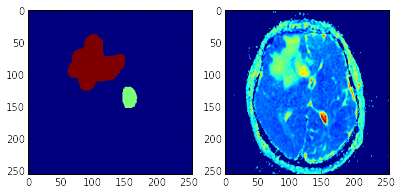

In [26]:
%matplotlib inline
import pylab
idx = 1
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplot(131)
plt.imshow(Y[idx,0,:,:])
plt.subplot(132)
plt.imshow(X[idx,0,:,:])

### Cropping out the tumor

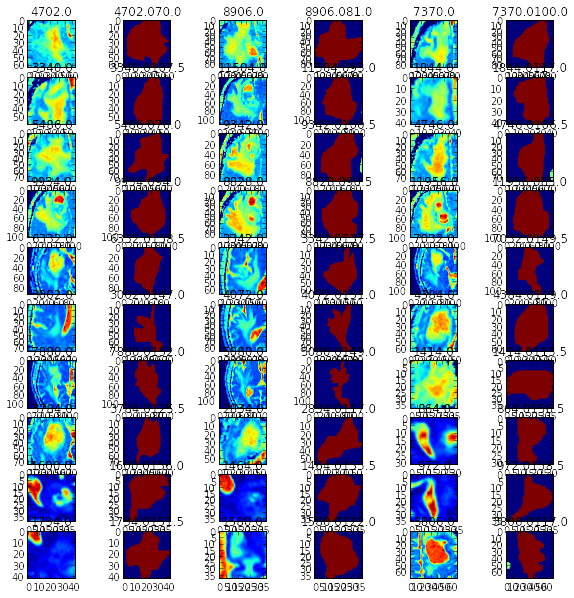

In [27]:
from scipy import ndimage
# Some code taken from: http://scipy-lectures.github.io/advanced/image_processing/
def getLargestTumor(img, idx):
    img[img == 1] = 0
    mask, num = ndimage.label(img)
    sizes = ndimage.sum(img, mask, range(num + 1))
    #plt.imshow(mask)
    maxCluster = np.argmax(sizes)
    if (maxCluster == 0):
        return None
    slice_x, slice_y = ndimage.find_objects(mask == maxCluster)[0]
    #print(sizes[maxCluster])

    # Cropping the largest region 
    x_r = slice_x.stop - slice_x.start
    y_r = slice_y.stop - slice_y.start
    m = max(x_r,y_r)

    x_c = (slice_x.stop + slice_x.start) * 0.5
    y_c = (slice_y.stop + slice_y.start) * 0.5
    slice_x_new = slice(x_c - m/2, x_c + m/2)
    slice_y_new = slice(y_c - m/2, y_c + m/2)

    return (X[idx,0,slice_x_new, slice_y_new],
            Y[idx,0,slice_x_new, slice_y_new], sizes[maxCluster],x_c, y_c)

allSlices = 0 
for i in range(0,numFiles):
    res = None
    try:
        res = getLargestTumor(np.copy(Y[i,0,:,:]), i)
        if (res != None):
            if (allSlices < 30):
                plt.subplot(10,6,2*allSlices+1)
                plt.imshow(res[0])
                plt.title(str(res[2]))
                plt.subplot(10,6,2*allSlices+2)
                plt.imshow(res[1])
                plt.title(str(res[2]) + str(res[3]))
            allSlices = allSlices + 1
    except IndexError:
        pass

500

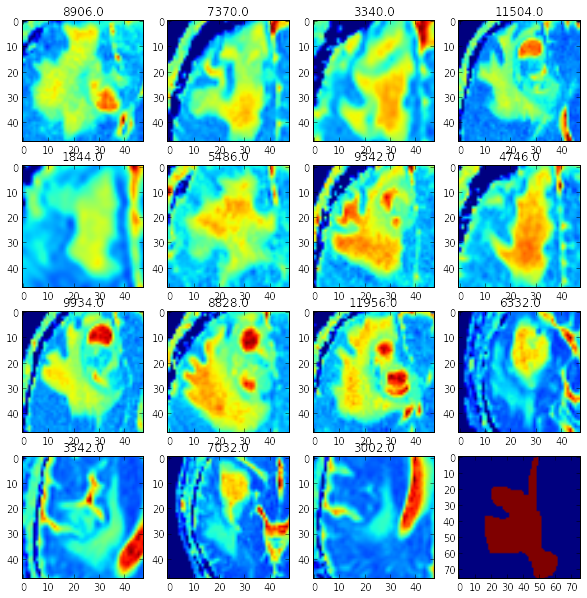

In [28]:
import cv2
numFiles = len(X)  # For Metastasis
X_out = np.zeros((numFiles,1,SHAPE[0], SHAPE[1])) #Change after all slices have been found
Y_out = np.zeros(numFiles)
Names_out = [None] * numFiles
allSlices = 0 
for i in range(0, numFiles):
    res = None
    try:
        res = getLargestTumor(np.copy(Y[i,0,:,:]), i)
        if (res != None):
            img = res[0]
            dd = cv2.resize(img,(48, 48))
            if (allSlices < 16):
                plt.imshow(dd)
                plt.title(str(res[2]))
                plt.subplot(4,4,allSlices+1)
                plt.imshow(res[1])
            X_out[allSlices,] = dd 
            Y_out[allSlices] = tumor_label
            Names_out[allSlices] = Names[i]
            allSlices += 1
    except IndexError:
        pass
allSlices

In [31]:
with open('/home/dueo/data/Inselspital_2015_07_08/GBM_tumors.pickle', 'wb') as f:
    pickle.dump((Names_out[0:allSlices],X_out[0:allSlices,:,:,:],Y_out[0:allSlices]), f, -1)
%ls -rtlh /home/dueo/data/Inselspital_2015_07_08/

total 3.1G
drwxr-xr-x 62 dueo dueo  4.0K Jun  5 04:43 GBM/
drwxr-xr-x 68 dueo dueo  4.0K Jun  5 05:26 metastasis/
-rw-r--r--  1 dueo dueo  455M Jun 18 16:21 metastasis.zip
-rw-r--r--  1 dueo dueo  509M Jun 18 16:22 GBM.zip
-rw-r--r--  1 dueo dueo  269K Jun 23 13:05 list_GBM.txt
-rw-r--r--  1 dueo dueo  282K Jun 23 13:07 list_meta.txt
-r--r--r--  1 dueo dueo  1.1G Jul 16 17:31 GBM.pickle
-r--r--r--  1 dueo dueo 1003M Jul 17 14:01 META.pickle
-rw-r--r--  1 dueo dueo  9.1M Jul 17 16:12 META_sub.pickle
-rw-r--r--  1 dueo dueo  9.1M Jul 17 16:12 GBM_sub.pickle
-rw-r--r--  1 dueo dueo  7.6M Jul 20 13:59 META_tumors.pickle
-rw-r--r--  1 dueo dueo  8.9M Jul 20 14:01 GBM_tumors.pickle


In [32]:
Y_out[0:allSlices]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2